In [1]:
from ase.io import read
import matplotlib.pyplot as plt

from abtem import FrozenPhonons, Potential, PlaneWave, Waves

# Multislice simulations (ED and CBED)

The multislice algorithm works by propagating the 2D lateral part of the wave function slice-by-slice forward along the optical axis (which in abTEM is by definition the positive `z` direction). A forward step through a slice of the potential consists of a transmission and a propagation. The `Wave` objects can be transmitted through a potential slice, which in the weak-phase approximation is just a phase shift. To complete one forward step, the transmitted wave is then propagated by a distance corresponding to the thickness of the slice using the Fresnel free-space approximation.

We import the potential from the previous tutorial. We tile the potential to get a better Fourier space sampling in the diffraction patterns. We also set up a plane wave with an energy of 300 keV.

In [32]:
atoms = read('data/srtio3_110.cif')

potential = Potential(atoms, slice_thickness=1)

wave = PlaneWave(energy=300e3, sampling=.05)
wave.grid.match(potential)

To propagate the wave function through the potential we use the `.multislice` method.

In [33]:
pw_exit_wave = wave.multislice(potential)

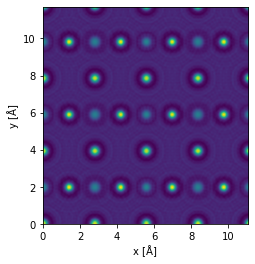

In [34]:
pw_exit_wave.show();

In [35]:
pw_exit_wave.axes_metadata

[FrozenPhononsAxis(),
 RealSpaceAxis(sampling=0.04997737556561086, label='x', units='Å', offset=0.0, endpoint=False),
 RealSpaceAxis(sampling=0.04997737556561086, label='y', units='Å', offset=0.0, endpoint=False)]

We show the intensity of the resulting exit wave.

In [36]:
pw_exit_wave.to_zarr('data/srtio3_110_exit_wave.zarr', overwrite=True)

imported_wave = Waves.from_zarr('data/srtio3_110_exit_wave.zarr')

The electron diffraction pattern can be obtained using the `.diffraction_patterns` method. We set `block_direct=True` as the direct beam is much higher intensity than the scattered beams and thus we can't show it on the same scale.

In [37]:
pw_diffraction_pattern = pw_exit_wave.diffraction_patterns(block_direct=True)

The be able to show the diffraction spots, we have to block the zeroth order spot. We also plot the diffraction pattern on a power scale to reveal slightly more higher order reflections, we set the power to `0.5`.

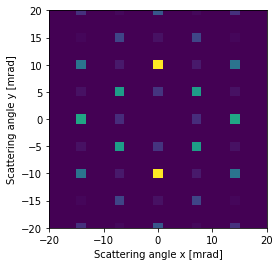

In [39]:
ax, im = pw_diffraction_pattern.show(power=.75)

ax.set_xlim([-20, 20])
ax.set_ylim([-20, 20]);

It may be unexpected that the diffraction spot looks like squares, this is because the incoming beam is an infinite coherent plane wave, which means that the diffraction spots are single points. However, we are discretizing the wave function on a square grid, hence the spots can only be as small as single pixels.

<div class= "alert alert-info">

**Note:**

You may have noted that the grid of the wave function was not given above. Using the multislice function, the wave function just adopts the grid of the potential before starting the multislice propagation. On the other hand, the following will result in a runtime error because the sampling cannot be inferred from the information given.

```python
wave = PlaneWave(energy=300e3)
potential = Potential(atoms)
exit_wave = wave.multislice(potential)
```

The next bit of code will also result in an error because the sampling of the wave function and the potential is different.

```python
wave = PlaneWave(sampling=.1, energy=300e3)
potential = Potential(atoms, sampling=.05)
exit_wave = wave.multislice(potential)
```
    
</div>

## Multislice simulation with probe

For a probe, we additionally define the probe convergence semiangle (in mrad) via `semiangle_cutoff`. Imaging modes utilizing an electron probe requires us to provide a positions for the probe (here a single location at 5 Å both in $x$ and $y$).

In [32]:
from abtem.waves import Probe

probe = Probe(energy=300e3, semiangle_cutoff=20, sampling=.01)
probe.grid.match(potential)
probe.build()

We can position the probe close to an atom by reloading our SrTiO$_3$ model, and reading the `xy` position of one of the Sr atoms.

In [33]:
position = atoms.positions[200][:2]

position

array([5.5225    , 7.81003905])

We then simulate the exit wave via a multislice simulation of the probe placed at this position.

In [34]:
probe_exit_wave = probe.multislice(positions=position, potential=potential)

In [35]:
probe_exit_wave.axes_metadata

[FrozenPhononsAxis(),
 {'type': 'positions'},
 RealSpaceAxis(sampling=0.04997737556561086, label='x', units='Å', offset=0.0, endpoint=False),
 RealSpaceAxis(sampling=0.04997737556561086, label='y', units='Å', offset=0.0, endpoint=False)]

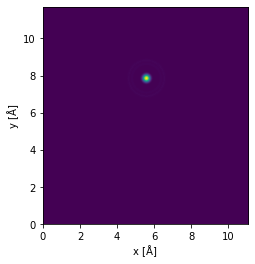

In [46]:
probe_exit_wave.show();

The convergent-beam electron diffraction (CBED) pattern can be calculated in the same manner as the ED pattern. We again display the result on a log scale. Note that to get more useful results, we should go back and increase our sampling of the potential.

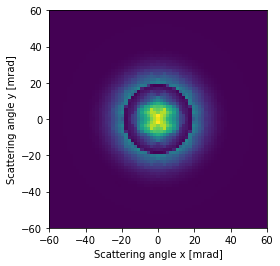

In [47]:
cbed_diffraction_pattern = probe_exit_wave.diffraction_patterns()

ax, im = cbed_diffraction_pattern.show()
ax.set_xlim([-60,60])
ax.set_ylim([-60,60]);